# Whether a NBA Team Will Enter The Playoff Since 2000

This project is a classification problem.

I will use r classification models: Random Forest Classifier, LogisticRegression, Support Vector Classifier, and Decision Tree Classifier to predict whether a team will enter the playoff since 2000 based on some categorical and numerical variables--Season Year, Team Name, Offensive rating & Defensive rating(Net Rating)--during the regular season.
* Project is based on data since 2000 because scoring strategy is totally different between 20th century and 21th century. More popularity of Three-point Score may make offense rating higher.

In [2]:
# Import all function packages I need.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier

In [3]:
df = pd.read_csv('NBA.csv') # Import NBA Stats Dataset since 1947
df.head() # Show the head of dataset to make each column visible

,season,lg,team,abbreviation,playoffs,age,w,l,pw,pl,...,tov_percent,orb_percent,ft_fga,opp_e_fg_percent,opp_tov_percent,opp_drb_percent,opp_ft_fga,arena,attend,attend_g
0,2024,NBA,Atlanta Hawks,ATL,False,26.2,36.0,46.0,36.0,46.0,...,11.6,27.1,0.200,0.572,12.4,75.2,0.192,State Farm Arena,696418.0,16986.0
1,2024,NBA,Boston Celtics,BOS,True,28.2,64.0,18.0,66.0,16.0,...,10.8,24.9,0.180,0.523,10.8,76.3,0.145,TD Garden,766240.0,18689.0
2,2024,NBA,Brooklyn Nets,BRK,False,26.1,32.0,50.0,34.0,48.0,...,11.8,25.2,0.177,0.543,11.4,76.0,0.193,Barclays Center,720291.0,17568.0
3,2024,NBA,Chicago Bulls,CHI,False,28.1,39.0,43.0,37.0,45.0,...,11.0,25.1,0.187,0.556,12.7,76.4,0.195,United Center,845620.0,20625.0
4,2024,NBA,Charlotte Hornets,CHO,False,25.1,21.0,61.0,18.0,64.0,...,12.6,21.1,0.167,0.572,12.3,74.5,0.188,Spectrum Center,674400.0,16449.0


## 1. Data Cleaning & Processing
Because this classification prediction project is only based on a variable, which is net rating computed by offensive rating & defensive rating. So, some other stats can be deleted from df and only keep several columns needed.
* o_rtg: offensive rating
* d_rtg: defensive rating
* n_rtg: net rating = offensive rating - defensive rating

In [4]:
# Renew df to a dataframe only include columns 'season', 'team', 'abbreviation', 'playoffs', 'o_rtg', 'd_rtg'
df = df.loc[:, ['season', 'team', 'abbreviation', 'playoffs', 'o_rtg', 'd_rtg', 'n_rtg']]
df.head() # check

,season,team,abbreviation,playoffs,o_rtg,d_rtg,n_rtg
0,2024,Atlanta Hawks,ATL,False,117.2,119.4,-2.2
1,2024,Boston Celtics,BOS,True,123.2,111.6,11.6
2,2024,Brooklyn Nets,BRK,False,113.2,116.1,-2.9
3,2024,Chicago Bulls,CHI,False,114.9,116.3,-1.4
4,2024,Charlotte Hornets,CHO,False,109.3,119.8,-10.5


In [5]:
# Just to Make Sure: Drop rows with NA
df = df.dropna(axis=0)
df.shape

(1709, 7)

Don't forget to keep years since 2000

In [6]:
df = df[df['season'] > 1999] # season number is higher than 1999 means since 2000
df.iloc[::-1] # check

,season,team,abbreviation,playoffs,o_rtg,d_rtg,n_rtg
768,2000,Washington Wizards,WAS,False,103.5,107.0,-3.5
767,2000,Vancouver Grizzlies,VAN,False,102.3,108.5,-6.2
766,2000,Utah Jazz,UTA,True,107.3,102.3,5.0
765,2000,Toronto Raptors,TOR,True,104.7,104.9,-0.2
764,2000,Seattle SuperSonics,SEA,True,105.6,104.6,1.0
...,...,...,...,...,...,...,...
4,2024,Charlotte Hornets,CHO,False,109.3,119.8,-10.5
3,2024,Chicago Bulls,CHI,False,114.9,116.3,-1.4
2,2024,Brooklyn Nets,BRK,False,113.2,116.1,-2.9
1,2024,Boston Celtics,BOS,True,123.2,111.6,11.6


Due to history name modification over time, we need to make the historical name to the current name.
Source is based on Wikipedia.

In [7]:
# New Orleans
df.loc[df['team'] == 'New Orleans/Oklahoma City Hornets', 'team'] = 'New Orleans Pelicans'
df.loc[df['team'] == 'New Orleans Hornets', 'team'] = 'New Orleans Pelicans'
df.loc[df['abbreviation'] == 'NOK', 'abbreviation'] = 'NOP'
df.loc[df['abbreviation'] == 'NOH', 'abbreviation'] = 'NOP'
df[df['team'] == 'New Orleans Pelicans']# check

,season,team,abbreviation,playoffs,o_rtg,d_rtg,n_rtg
18,2024,New Orleans Pelicans,NOP,False,117.4,112.9,4.5
49,2023,New Orleans Pelicans,NOP,False,114.4,112.5,1.9
80,2022,New Orleans Pelicans,NOP,True,112.0,113.0,-1.0
111,2021,New Orleans Pelicans,NOP,False,113.5,113.8,-0.3
142,2020,New Orleans Pelicans,NOP,False,110.7,111.9,-1.2
173,2019,New Orleans Pelicans,NOP,False,111.4,112.6,-1.2
204,2018,New Orleans Pelicans,NOP,True,109.6,108.3,1.3
235,2017,New Orleans Pelicans,NOP,False,105.2,107.4,-2.2
266,2016,New Orleans Pelicans,NOP,False,105.6,109.5,-3.9
297,2015,New Orleans Pelicans,NOP,True,108.2,107.3,0.9


In [8]:
# Charlotte
df.loc[df['team'] == 'Charlotte Bobcats', 'team'] = 'Charlotte Hornets'
df.loc[df['abbreviation'] == 'CHA', 'abbreviation'] = 'CHO'
df.loc[df['abbreviation'] == 'CHH', 'abbreviation'] = 'CHO'
df[df['team'] == 'Charlotte Hornets']

,season,team,abbreviation,playoffs,o_rtg,d_rtg,n_rtg
4,2024,Charlotte Hornets,CHO,False,109.3,119.8,-10.5
35,2023,Charlotte Hornets,CHO,False,109.2,115.3,-6.1
66,2022,Charlotte Hornets,CHO,False,114.1,113.7,0.4
97,2021,Charlotte Hornets,CHO,False,110.9,112.8,-1.9
128,2020,Charlotte Hornets,CHO,False,106.3,113.3,-7.0
159,2019,Charlotte Hornets,CHO,False,111.4,112.5,-1.1
190,2018,Charlotte Hornets,CHO,False,109.4,109.1,0.3
221,2017,Charlotte Hornets,CHO,False,108.8,108.6,0.2
252,2016,Charlotte Hornets,CHO,True,107.1,104.3,2.8
283,2015,Charlotte Hornets,CHO,False,100.1,103.5,-3.4


In [9]:
# Seattle Supersonics to Oklahoma City Thunder
df.loc[df['team'] == 'Seattle SuperSonics', 'team'] = 'Oklahoma City Thunder'
df.loc[df['abbreviation'] == 'SEA', 'abbreviation'] = 'OKC'
df[df['team'] == 'Oklahoma City Thunder'] # check

,season,team,abbreviation,playoffs,o_rtg,d_rtg,n_rtg
20,2024,Oklahoma City Thunder,OKC,True,119.5,112.1,7.4
51,2023,Oklahoma City Thunder,OKC,False,115.2,114.2,1.0
82,2022,Oklahoma City Thunder,OKC,False,104.6,112.8,-8.2
113,2021,Oklahoma City Thunder,OKC,False,103.5,114.0,-10.5
144,2020,Oklahoma City Thunder,OKC,True,110.8,108.8,2.0
175,2019,Oklahoma City Thunder,OKC,True,110.3,107.0,3.3
206,2018,Oklahoma City Thunder,OKC,True,110.7,107.2,3.5
237,2017,Oklahoma City Thunder,OKC,True,108.3,107.5,0.8
268,2016,Oklahoma City Thunder,OKC,True,113.1,105.6,7.5
299,2015,Oklahoma City Thunder,OKC,False,107.8,105.5,2.3


In [10]:
# Vancouver Grizzlies to Memphis Grizzlies
df.loc[df['team'] == 'Vancouver Grizzlies', 'team'] = 'Memphis Grizzlies'
df.loc[df['abbreviation'] == 'VAN', 'abbreviation'] = 'MEM'
df[df['team'] == 'Memphis Grizzlies'] # check

,season,team,abbreviation,playoffs,o_rtg,d_rtg,n_rtg
14,2024,Memphis Grizzlies,MEM,False,107.2,114.3,-7.1
45,2023,Memphis Grizzlies,MEM,False,115.1,111.2,3.9
76,2022,Memphis Grizzlies,MEM,True,114.6,109.0,5.6
107,2021,Memphis Grizzlies,MEM,True,112.0,111.0,1.0
138,2020,Memphis Grizzlies,MEM,False,109.2,110.3,-1.1
169,2019,Memphis Grizzlies,MEM,False,106.1,108.8,-2.7
200,2018,Memphis Grizzlies,MEM,False,104.5,111.0,-6.5
231,2017,Memphis Grizzlies,MEM,True,107.7,107.1,0.6
262,2016,Memphis Grizzlies,MEM,True,105.4,107.8,-2.4
293,2015,Memphis Grizzlies,MEM,True,105.7,102.2,3.5


In [11]:
# New Jersey Nets to Brooklyn Nets
df.loc[df['team'] == 'New Jersey Nets', 'team'] = 'Brooklyn Nets'
df.loc[df['abbreviation'] == 'NJN', 'abbreviation'] = 'BRK'
df[df['team'] == 'Brooklyn Nets'] # check

,season,team,abbreviation,playoffs,o_rtg,d_rtg,n_rtg
2,2024,Brooklyn Nets,BRK,False,113.2,116.1,-2.9
33,2023,Brooklyn Nets,BRK,False,115.0,114.1,0.9
64,2022,Brooklyn Nets,BRK,True,113.6,112.8,0.8
95,2021,Brooklyn Nets,BRK,True,118.3,113.8,4.5
126,2020,Brooklyn Nets,BRK,True,108.9,109.5,-0.6
157,2019,Brooklyn Nets,BRK,True,109.6,109.7,-0.1
188,2018,Brooklyn Nets,BRK,False,106.9,110.6,-3.7
219,2017,Brooklyn Nets,BRK,False,104.1,110.7,-6.6
250,2016,Brooklyn Nets,BRK,False,103.2,110.9,-7.7
281,2015,Brooklyn Nets,BRK,True,104.4,107.4,-3.0


In [12]:
type(df['playoffs'][1])

numpy.bool_

In [13]:
df.to_csv("NBA_Playoffs.csv", index=False)

The elements in the playoffs column are boolean type. For classification problems, it's common to convert categorical target labels or boolean type like 'True' and 'False' to numerical values like 1 and 0. This makes it easier for most machine learning algorithms to process the data. This ensures compatibility with the algorithms and helps in computation, making it more efficient for the model to interpret the data.

* 0 - False(Fail to playoffs)
* 1 - True(Success to playoffs)

In [14]:
# Convert boolean 'Playoffs' column to integer 0/1
df['playoffs'] = df['playoffs'].astype(int)

## 2. Algorithms & Models

In [15]:
# Define features and target
X = df[['n_rtg', 'season', 'team']]
y = df['playoffs']

In the next step, we define a ColumnTransformer to preprocess the features before training the models.
This includes:
1. Standardizing numerical features ('NetRating' and 'SeasonYear') using StandardScaler to ensure all numerical features are on a similar scale.
2. Encoding the categorical feature ('TeamName') using OneHotEncoder to convert team names into a format suitable for machine learning models.
3. 
Season Year and Team Name should be considered when training the model because they provide valuable contextual information that can help improve predictive accuracy.
- Season: Each season can have different dynamics due to factors like rule changes, player trades, and injuries. Including the SeasonYear feature allows the model to capture the effect of these year-specific differences.
- Team: Including the TeamName as a feature allows the model to take into account the consistency and historical strength of specific teams, which is critical in predicting playoff qualification.


In [16]:
# Preprocessing for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('net_rating', StandardScaler(), ['n_rtg']), 
        ('season', OrdinalEncoder(), ['season']), # Using OrdinalEncoder means treating it as a numerical feature with ordered values, implying a progression from one year to the next.
        ('team', OneHotEncoder(), ['team'])# One-hot encoding is generally used when there's no ordinal relationship between categories. Every team name is independent.
    ]
)

### A. Random Forest

1. Let's start with Random Forest because it is well-suited for capturing non-linear relationships and complex interactions between features such as Net Rating, Season Year, and Team Name. Random Forest is an ensemble learning method that constructs multiple decision trees during training and merges them to produce more accurate and stable predictions. It is also relatively robust to overfitting and generally provides good predictive performance in a variety of cases.
* For the given problem, where net rating, season year, and team name might have complex interactions, I think Random Forest is likely the best model as it can effectively capture non-linear patterns in the data.

In [17]:
# Creat a pipeline for this model
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

Now we split data into train and test sets.
1. test_size=0.2: This specifies that 20% of the data will be used for testing, while 80% will be used for training. The split ratio is chosen to provide enough data to train the model effectively while reserving a reasonable amount for evaluating its performance.
2. random_state=42: This is used to ensure reproducibility. By setting a fixed random state, you ensure that the data split is consistent across different runs, making the results more comparable. The number 42 is arbitrary; it could be any integer, but 42 is commonly used as a convention.

In [18]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Random Forest Classifier
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
rf_proba = rf_pipeline.predict_proba(X_test)[:, 1]
print("Random Forest Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(classification_report(y_test, y_pred_rf))

Random Forest Results:
Accuracy: 0.8926174496644296
              precision    recall  f1-score   support

           0       0.92      0.83      0.87        66
           1       0.88      0.94      0.91        83

    accuracy                           0.89       149
   macro avg       0.90      0.89      0.89       149
weighted avg       0.89      0.89      0.89       149



Actually, during the time I change the historic team name to current name to make them unified, I found the accuracy increased before changing team name to uniform. (Accuracy f1-score: from 0.87 to 0.89)

### B. Logistic Regression
Now, let's try another one model, Logistic Regression. Logistic Regression is a linear model for binary classification that estimates the probability that a team will make the playoffs based on the given features.

In [20]:
# Create pipelines for Logistic Regression Model
logistic_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

In [21]:
# Logistic Regression
logistic_pipeline.fit(X_train, y_train)
y_pred_logistic = logistic_pipeline.predict(X_test)
logistic_proba = logistic_pipeline.predict_proba(X_test)[:, 1]
print("\nLogistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_logistic)}")
print(classification_report(y_test, y_pred_logistic))


Logistic Regression Results:
Accuracy: 0.8657718120805369
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        66
           1       0.89      0.87      0.88        83

    accuracy                           0.87       149
   macro avg       0.86      0.87      0.86       149
weighted avg       0.87      0.87      0.87       149



### C. Support Vector Machine(SVM)
Now, let's try Support Vector Machine (SVM). SVM is a powerful classifier that aims to find a hyperplane that best separates the classes in a high-dimensional space. We use a linear kernel for SVM to capture relationships between the features while maintaining computational efficiency. SVM can be effective when the decision boundary is clear, making it a good candidate for comparison.



In [22]:
# Create pipelines for SVM model
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='linear', probability=True))
])

In [23]:
# Support Vector Machine
svm_pipeline.fit(X_train, y_train)
y_pred_svm = svm_pipeline.predict(X_test)
svm_proba = svm_pipeline.predict_proba(X_test)[:, 1]
print("\nSupport Vector Machine Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm)}")
print(classification_report(y_test, y_pred_svm))


Support Vector Machine Results:
Accuracy: 0.8657718120805369
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        66
           1       0.88      0.88      0.88        83

    accuracy                           0.87       149
   macro avg       0.86      0.86      0.86       149
weighted avg       0.87      0.87      0.87       149



### D. Decision Tree Classifier
Finally, let's try Decision Tree Classifier. The Decision Tree Classifier is a machine learning algorithm that makes decisions based on the values of input features to classify data points. It works by splitting the dataset into smaller subsets based on conditions, effectively creating a tree-like model of decisions.

In [24]:
# Decision Tree Classifier Pipeline
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=5, min_samples_split=5, min_samples_leaf=3, random_state=42)) # prevent overfitting to increase accuracy
])

* max_depth=5: This restricts how complex the model can become, preventing it from overfitting to the training data by learning unnecessary details or noise.

* min_samples_split=5: Specifies that a node must have at least 5 samples before it can be split further. This prevents the tree from creating splits that would result in very small groups, which often do not generalize well.

* min_samples_leaf=3: Requires each leaf node to have at least 3 samples. This prevents the tree from creating very small leaf nodes, which can contribute to overfitting by making predictions based on a very small number of data points.

In [25]:
# Decision Tree Classifier
dt_pipeline.fit(X_train, y_train)
y_pred_dt = dt_pipeline.predict(X_test)
dt_proba = dt_pipeline.predict_proba(X_test)[:, 1]
print("Decision Tree Classifier Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt)}")
print(classification_report(y_test, y_pred_dt))

Decision Tree Classifier Results:
Accuracy: 0.8791946308724832
              precision    recall  f1-score   support

           0       0.91      0.80      0.85        66
           1       0.86      0.94      0.90        83

    accuracy                           0.88       149
   macro avg       0.89      0.87      0.88       149
weighted avg       0.88      0.88      0.88       149



##### The Random Forest Classifier performed the best among the models tested, achieving the highest accuracy in predicting playoff participation, which is about 0.893. Other models approximately get 0.866, 0.866 and 0.879, which is a bit lower than the accuracy value Random Forest Classifier gets.
##### So, my hypothesis about using Random Forest as the best classifier in the beginning is correct.

## 3. More Ways of Evaluation
1. #### Confusion Matrix
2. #### Precision-recall Curve
3. #### ROC Curve

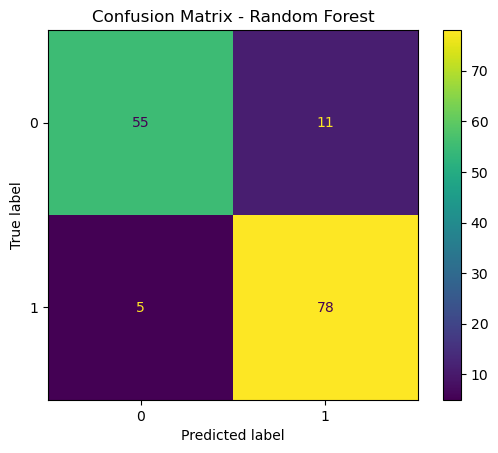

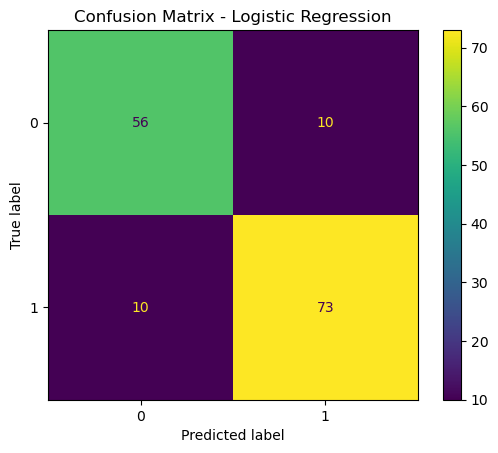

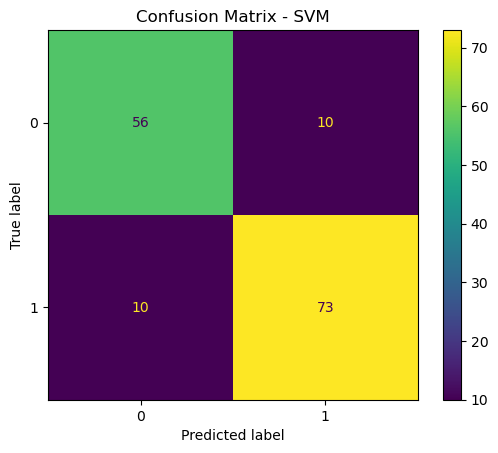

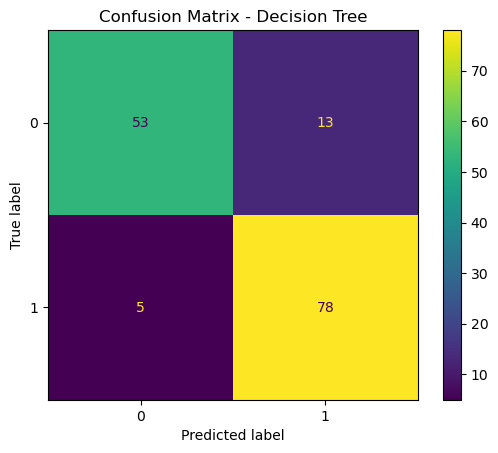

In [26]:
# Plot Confusion Matrix for Random Forest
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)
plt.title('Confusion Matrix - Random Forest')
# Plot Confusion Matrix for Logistic Regression
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm)
plt.title('Confusion Matrix - Logistic Regression')
# Plot Confusion Matrix for SVM
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm)
plt.title('Confusion Matrix - SVM')
# Plot Confusion Matrix for SVM
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt)
plt.title('Confusion Matrix - Decision Tree')
plt.show()


#### From the above four confusion matrix, we can observe that Random Forest Classifier gives out more correct prediction, which is 55 + 78 = 133. Others three respectively give out 129, 129, 131 correct predictions.
- True Negatives (Top-left)
- False Positives (Top-right)
- False Negatives (Bottom-left)
- True Positives (Bottom-right)

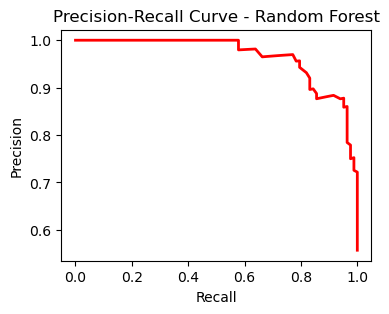

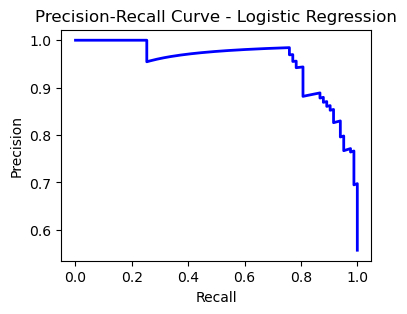

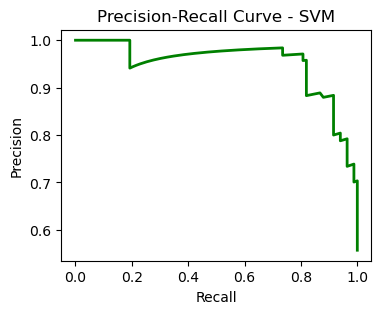

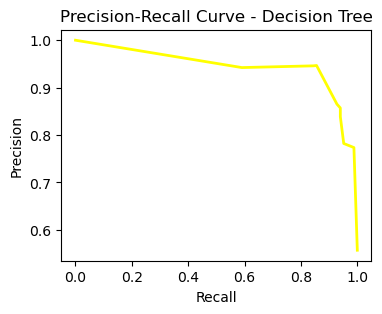

In [27]:
# Plot Precision-Recall Curve for Random Forest
precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_proba)
plt.figure(figsize=(4, 3))
plt.plot(recall_rf, precision_rf, color='red', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Random Forest')

# Plot Precision-Recall Curve for Random Forest
precision_lr, recall_lr, _ = precision_recall_curve(y_test, logistic_proba)
plt.figure(figsize=(4, 3))
plt.plot(recall_lr, precision_lr, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Logistic Regression')

# Plot Precision-Recall Curve for SVM
precision_svm, recall_svm, _ = precision_recall_curve(y_test, svm_proba)
plt.figure(figsize=(4, 3))
plt.plot(recall_svm, precision_svm, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - SVM')

# Plot Precision-Recall Curve for SVM
precision_dt, recall_dt, _ = precision_recall_curve(y_test, dt_proba)
plt.figure(figsize=(4, 3))
plt.plot(recall_dt, precision_dt, color='yellow', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Decision Tree')

plt.show() # show

#### Random Forest:
- The curve for Random Forest starts at high precision (near 1) and remains relatively stable until around 0.8 recall, after which it starts declining.
- The curve indicates that Random Forest is good at maintaining high precision while increasing recall, demonstrating its effectiveness at distinguishing between classes.
#### Logistic Regression & SVM (Support Vector Machine)
- The precision-recall curves for Logistic Regression and SVM also start at a high precision but have an earlier decline are less stable compared to Random Forest.
#### Decision Tree:
- The precision-recall curve for Decision Tree has the earliest decline start from 0.0 recall and the decline is steeper compared to the other models.
- This behavior indicates that the Decision Tree is less stable and struggles with maintaining precision as it tries to recall more positive instances. This is consistent with the model's tendency to overfit.
##### Overall, Random Forest has a strong balance of precision and recall, which is expected due to its ability to combine multiple decision trees.


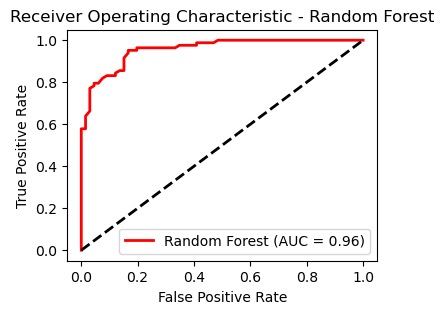

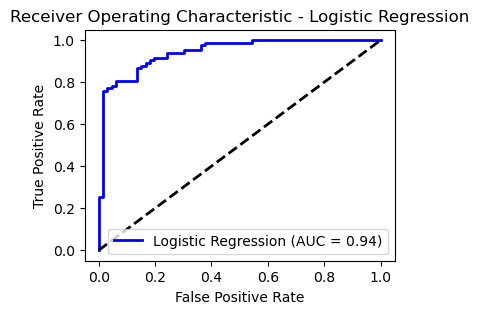

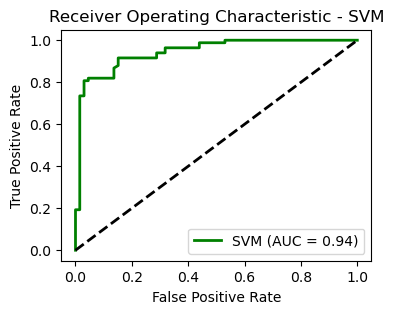

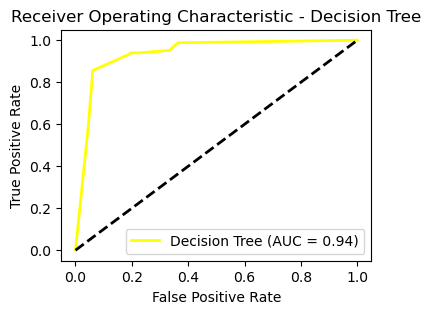

In [28]:
# Plot ROC Curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(4, 3))
plt.plot(fpr_rf, tpr_rf, color='red', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Random Forest')
plt.legend(loc='lower right')

# Plot ROC Curve for Logistic Regression
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, logistic_proba)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)
plt.figure(figsize=(4, 3))
plt.plot(fpr_logistic, tpr_logistic, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_logistic:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.legend(loc='lower right')

# Plot ROC Curve for SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_proba)
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.figure(figsize=(4, 3))
plt.plot(fpr_svm, tpr_svm, color='green', lw=2, label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - SVM')
plt.legend(loc='lower right')

# Plot ROC Curve for SVM
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_proba)
roc_auc_dt = auc(fpr_dt, tpr_dt)
plt.figure(figsize=(4, 3))
plt.plot(fpr_dt, tpr_dt, color='yellow', lw=2, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Decision Tree')
plt.legend(loc='lower right')

plt.show()

#### Random Forest AUC: 0.96
#### Others AUC: 0.94
##### Random Forest has the highest AUC (0.96), indicating the best overall performance among the models in distinguishing between playoff and non-playoff teams.
##### Decision Tree also has an AUC of 0.94 like Logistic Regression and SVM, but the curve is less consistent, suggesting potential overfitting or sensitivity to the dataset.